# Práctica 1: Aprendizaje automático

__Fecha de entrega: 13 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 15__

__Nombres de los estudiantes: Javier Sande Ríos y Mario Sanz Guerrero__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

#### Solución:

In [1]:
import numpy as np
import pandas as pd

In [2]:
# La función read_csv ya nos devuelve un DataFrame, así que no hace falta convertirlo
df = pd.read_csv('prestamos.csv')
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


Del dataframe anterior, vamos a crear dos dataframes nuevos: uno que solo tenga variables numéricas y otro que solo tenga variables categóricas.

In [3]:
df_num = df.drop(['purpose', 'home_ownership_n', 'emp_length_n', 'Default'], axis=1)
df_num

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.0,18.93,687.0
1,32000,90000.0,9.29,822.0
2,30000,95000.0,1.34,722.0
3,25750,230000.0,6.42,747.0
4,25200,72000.0,30.95,692.0
...,...,...,...,...
13789,1275,42000.0,31.89,792.0
13790,1200,36000.0,12.27,747.0
13791,1000,76000.0,25.26,702.0
13792,1000,32000.0,17.70,747.0


In [4]:
df_cat = df[['purpose', 'home_ownership_n', 'emp_length_n', 'Default']]
df_cat

,purpose,home_ownership_n,emp_length_n,Default
0,car,MORTGAGE,1,0
1,car,MORTGAGE,10,1
2,car,RENT,11,0
3,car,MORTGAGE,11,0
4,car,OWN,11,0
...,...,...,...,...
13789,vacation,RENT,0,0
13790,vacation,MORTGAGE,8,0
13791,vacation,MORTGAGE,11,0
13792,vacation,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

#### Solución:

**Variables numéricas**

In [5]:
df_num.describe()

,loan_amnt,revenue,dti_n,fico_n
count,13794.000000,1.379400e+04,13794.000000,13794.000000
mean,14507.833116,7.973730e+04,18.825106,699.106822
std,9037.938271,5.646358e+04,9.795986,32.825754
min,1000.000000,7.000000e+03,0.000000,662.000000
25%,7300.000000,4.800000e+04,12.200000,672.000000
50%,12000.000000,6.800000e+04,18.085000,692.000000
75%,20000.000000,9.700000e+04,24.757500,717.000000
max,40000.000000,1.650000e+06,190.870000,847.500000


**Análisis:** 

**Diagrama de dispersión**

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

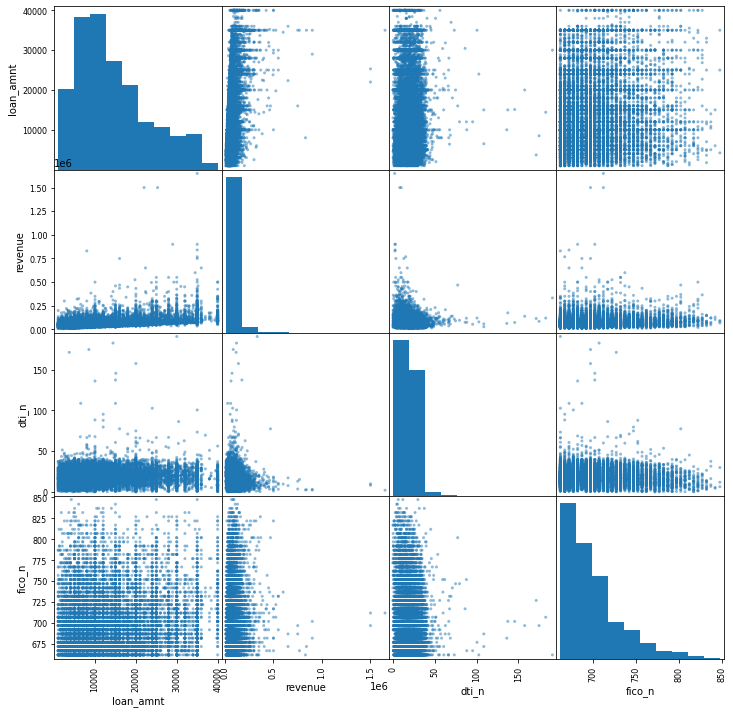

In [6]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(df_num, figsize = (12, 12), diagonal = 'hist')

**Análisis:** 

**Coeficientes de correlación entre pares de variables**

In [7]:
df_num.corr()

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000000,0.424460,0.034134,0.090869
revenue,0.424460,1.000000,-0.137616,0.091204
dti_n,0.034134,-0.137616,1.000000,-0.057580
fico_n,0.090869,0.091204,-0.057580,1.000000


**Análisis:** 


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

#### Solución:

<AxesSubplot:>

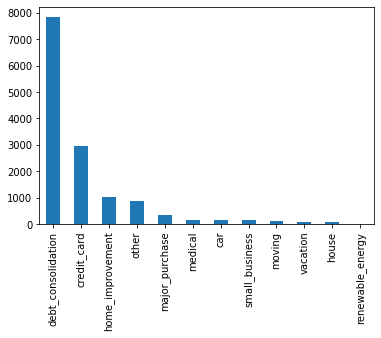

In [8]:
df_cat['purpose'].value_counts().plot.bar()

In [9]:
df_cat.groupby('purpose').describe()

emp_length_n                                           \
                          count      mean       std  min  25%  50%   75%   
purpose                                                                    
car                       154.0  6.006494  4.313676  0.0  2.0  6.0  11.0   
credit_card              2960.0  6.219257  3.963448  0.0  3.0  6.0  11.0   
debt_consolidation       7841.0  6.586022  3.997228  0.0  3.0  7.0  11.0   
home_improvement         1016.0  6.928150  3.966082  0.0  3.0  7.0  11.0   
house                      70.0  6.585714  3.827789  0.0  4.0  6.0  11.0   
major_purchase            337.0  6.581602  3.876058  0.0  3.0  6.0  11.0   
medical                   163.0  6.398773  3.862673  0.0  3.0  6.0  11.0   
moving                    124.0  5.056452  3.761816  0.0  2.0  4.0   8.0   
other                     883.0  6.323896  4.042765  0.0  3.0  6.0  11.0   
renewable_energy           13.0  7.076923  3.988766  1.0  3.0  7.0  11.0   
small_business            145.0  6.075862  3.849752  0.0  3.0  6.0  11.0   
vacation                   88.0  6.613636  4.015578  0.0  3.0  6.0  11.0   

                         Default                                               
                     max   count      mean       std  min  25%  50%  75%  max  
purpose                                                                        
car                 11.0   154.0  0.188312  0.392236  0.0  0.0  0.0  0.0  1.0  
credit_card         11.0  2960.0  0.181757  0.385709  0.0  0.0  0.0  0.0  1.0  
debt_consolidation  11.0  7841.0  0.236960  0.425244  0.0  0.0  0.0  0.0  1.0  
home_improvement    11.0  1016.0  0.180118  0.384475  0.0  0.0  0.0  0.0  1.0  
house               11.0    70.0  0.285714  0.455016  0.0  0.0  0.0  1.0  1.0  
major_purchase      11.0   337.0  0.189911  0.392814  0.0  0.0  0.0  0.0  1.0  
medical             11.0   163.0  0.202454  0.403067  0.0  0.0  0.0  0.0  1.0  
moving              11.0   124.0  0.201613  0.402832  0.0  0.0  0.0  0.0  1.0  
other               11.0   883.0  0.219706  0.414282  0.0  0.0  0.0  0.0  1.0  
renewable_energy    11.0    13.0  0.307692  0.480384  0.0  0.0  0.0  1.0  1.0  
small_business      11.0   145.0  0.344828  0.476960  0.0  0.0  0.0  1.0  1.0  
vacation            11.0    88.0  0.125000  0.332614  0.0  0.0  0.0  0.0  1.0

<AxesSubplot:>

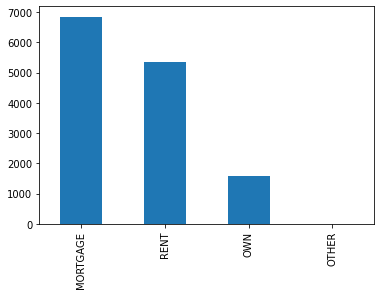

In [10]:
df_cat['home_ownership_n'].value_counts().plot.bar()

In [11]:
df_cat.groupby('home_ownership_n').describe()

emp_length_n                                                 \
                        count      mean       std  min  25%  50%   75%   max   
home_ownership_n                                                               
MORTGAGE               6850.0  7.077664  3.964337  0.0  3.0  8.0  11.0  11.0   
OTHER                     9.0  5.444444  2.242271  1.0  4.0  6.0   7.0   8.0   
OWN                    1586.0  6.336696  4.179128  0.0  3.0  6.0  11.0  11.0   
RENT                   5349.0  5.780707  3.850511  0.0  2.0  5.0  10.0  11.0   

                 Default                                               
                   count      mean       std  min  25%  50%  75%  max  
home_ownership_n                                                       
MORTGAGE          6850.0  0.185985  0.389123  0.0  0.0  0.0  0.0  1.0  
OTHER                9.0  0.222222  0.440959  0.0  0.0  0.0  0.0  1.0  
OWN               1586.0  0.222573  0.416105  0.0  0.0  0.0  0.0  1.0  
RENT              5349.0  0.257992  0.437571  0.0  0.0  0.0  1.0  1.0

<AxesSubplot:>

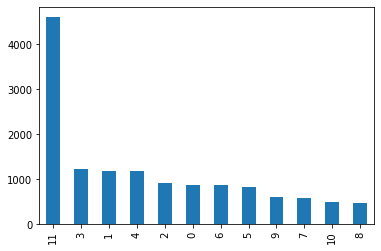

In [12]:
df_cat['emp_length_n'].value_counts().plot.bar()

In [13]:
df_cat.groupby('emp_length_n').describe()

Default                                             
               count      mean       std  min  25%  50%  75%  max
emp_length_n                                                     
0              875.0  0.297143  0.457261  0.0  0.0  0.0  1.0  1.0
1             1174.0  0.220613  0.414837  0.0  0.0  0.0  0.0  1.0
2              909.0  0.232123  0.422420  0.0  0.0  0.0  0.0  1.0
3             1232.0  0.215097  0.411057  0.0  0.0  0.0  0.0  1.0
4             1174.0  0.198467  0.399015  0.0  0.0  0.0  0.0  1.0
5              815.0  0.217178  0.412578  0.0  0.0  0.0  0.0  1.0
6              860.0  0.229070  0.420479  0.0  0.0  0.0  0.0  1.0
7              580.0  0.236207  0.425117  0.0  0.0  0.0  0.0  1.0
8              470.0  0.202128  0.402015  0.0  0.0  0.0  0.0  1.0
9              599.0  0.205342  0.404289  0.0  0.0  0.0  0.0  1.0
10             494.0  0.194332  0.396087  0.0  0.0  0.0  0.0  1.0
11            4612.0  0.207285  0.405406  0.0  0.0  0.0  0.0  1.0

<AxesSubplot:>

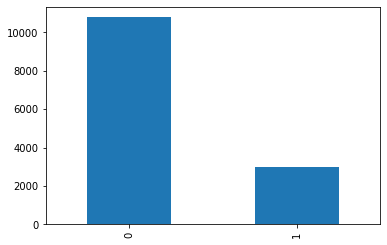

In [14]:
df_cat['Default'].value_counts().plot.bar()

In [15]:
df_cat.groupby('Default').describe()

emp_length_n                                               
               count      mean       std  min  25%  50%   75%   max
Default                                                            
0            10785.0  6.557719  3.969565  0.0  3.0  6.0  11.0  11.0
1             3009.0  6.240279  4.060352  0.0  3.0  6.0  11.0  11.0

**Análisis:** 

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

#### Solución:

In [16]:
df_ej3 = df[['loan_amnt', 'revenue', 'dti_n', 'fico_n']]
df_ej3

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.0,18.93,687.0
1,32000,90000.0,9.29,822.0
2,30000,95000.0,1.34,722.0
3,25750,230000.0,6.42,747.0
4,25200,72000.0,30.95,692.0
...,...,...,...,...
13789,1275,42000.0,31.89,792.0
13790,1200,36000.0,12.27,747.0
13791,1000,76000.0,25.26,702.0
13792,1000,32000.0,17.70,747.0


Estudiando el dataframe obtenido, sí que nos interesa estandarizar los datos porque, mientras que la variable `fico_n` tiene variaciones de en torno a 100 unidades, la variable `revenue` tiene varios miles de unidades de diferencia. Esto implicaría que la diferencia de uno de los ejes sería insignificante en comparación con la otra, creando clusters no representativos.

A continuación vamos a ver qué método nos interesa más basado en resultados, si el reescalado o la estandarización:

In [17]:
# REESCALADO
from sklearn.preprocessing import MinMaxScaler

# Transformamos las variables de entrada
scaler_x = MinMaxScaler()
scaler_x.fit(df_ej3)
data_scaled_minMax=scaler_x.transform(df_ej3)
df_reescalado = pd.DataFrame(data=data_scaled_minMax, columns=['loan_amnt', 'revenue', 'dti_n', 'fico_n'])
df_reescalado.head()

,loan_amnt,revenue,dti_n,fico_n
0,0.794872,0.077906,0.099177,0.134771
1,0.794872,0.050517,0.048672,0.862534
2,0.743590,0.053561,0.007020,0.323450
3,0.634615,0.135727,0.033635,0.458221
4,0.620513,0.039562,0.162152,0.161725


In [18]:
#ESTANDARIZACION
from sklearn.preprocessing import StandardScaler

# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(df_ej3)
data_scaled=scaler_x.transform(df_ej3)
df_estandarizado = pd.DataFrame(data=data_scaled, columns=['loan_amnt', 'revenue', 'dti_n', 'fico_n'])
df_estandarizado.head()

,loan_amnt,revenue,dti_n,fico_n
0,1.935486,0.978767,0.010708,-0.368834
1,1.935486,0.181764,-0.973404,3.743939
2,1.714188,0.270320,-1.784990,0.697440
3,1.243931,2.661329,-1.266392,1.459065
4,1.183075,-0.137037,1.237786,-0.216509


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Vamos a estratificar los datos a partir del resultado. Vamos a usar el 80% de los casos para
# entrenar y el 20% restante para las pruebas.
X_train, X_test, y_train, y_test = train_test_split(df_reescalado, df['Default'], 
                                                    test_size=0.20, stratify=df['Default'],
                                                    random_state=55)

# Creamos el clasificador k-NN, fijando los pesos inv. proporcionales a la distancia 'distance'
clf = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Medir la tasa de aciertos o exactitud (accuracy) en los conjuntos de entrenamiento y test
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

train_accuracy, test_accuracy

(1.0, 0.7535338890902501)

Para todas las pruebas de comparación realizadas entre el reescalado y la estandarización, el reescalado es ligeramente superior en la precisión de test, así que optaremos por la opción del reescalado.

## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

#### Solución:

A continuación vamos a ver cuál es el número óptimo de k para le algoritmo de k-means. Para ello, vamos a ver cómo varía el índice de Davies-Boulding (razón entre distancias intra-cluster y las distancias inter-cluster) para un número de agrupaciones entre 2 y 8.

Nuestro objetivo será tener el valor del índice lo más pequeño posible, lo cual indicará que los datos están mejor concentrados en su agrupación. Una escasez o exceso de grupos podría empeorar esta concentración de individuos en sus agrupaciones.

**Nota:** Como nos interesa estudiar la relación de las 4 variables numéricas del problema pero el ojo humano no puede ver en 4 dimensiones, hemos decidido no pintar los diagramas de dispersión de momento. El motivo es que para representar mejor las agrupaciones, hemos creado gráficas interactivas en 3 dimensiones para podernos mover por los ejes. El problema es que si pintamos todas estas gráficas en este ejercicio, nos quedarían 4 gráficas por cada k (4 combinaciones de 3 variables para las 3 dimensiones) y tenemos 6 valores distintos de k (de 2 a 7). Esto formaría un total de 24 gráficas en 3D, y como ocupan bastante en memoria, en este ejercicio (4) solamente vamos a obtener el valor óptimo de k, y en el siguiente ejercicio (5) pintaremos las 4 gráficas correspondientes solo para el valor óptimo de k, y podremos ver cómo se relacionan entre ellas.

In [21]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [22]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df_reescalado)
    # plot_clusters(data_scaled, km.labels_, km.cluster_centers_)
    
    davies_boulding[k-2] = davies_bouldin_score(df_reescalado, km.labels_)

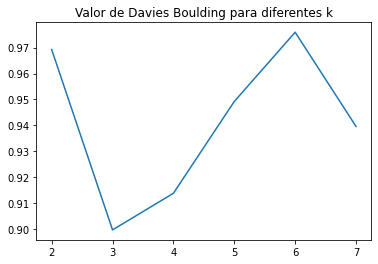

In [23]:
plt.clf()
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')
plt.show()

Como conclusión, vemos que el mejor valor obtenido para la k del algoritmo k-means es 3. Es decir, que la agrupación óptima de los individuos es en 3 grupos.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

#### Solución:

A continuación queremos ver cuál es el conjunto de variables numéricas que mejor diferencian a los clusters. Recordemos que estamos estudiando las variables numéricas, y en este problema concretamente tenemos cuatro. La mejor forma de identificar los clusters más diferenciadores es viendo las representaciones a ojo, pero el ojo humano no es capaz de ver las cuatro dimensiones a la vez. Es por ello que vamos a usar representaciones en grupos de 3 variables, para ver cuál de ellos es el conjunto que mejor define al número de clusters óptimo obtenido en el ejercicio anterior (lo óptimo es usar 3 clusters).

Para que sea más visual y facilitar la lectura de los datos, hemos decidido utilizar unos planos interactivos en 3D para poder ver la distancia de los puntos en la tercera dimensión. Para poder hacer funcionar esto, será necesaria la instalación de la librería `ipympl`, que es una integración de Matplotlib para los Jupyter Notebook para hacer las gráficas interactivas. Para instalarla, bastará con abrir una terminal y escribir `pip3 install ipympl`.

In [32]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
'loan_amnt', 'revenue', 'dti_n', 'fico_n'

def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    # GRAFICA 1 - 'loan_amnt', 'revenue', 'dti_n'
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax1.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax1.scatter(centers[:,0], centers[:,1], centers[:,2], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'revenue', 'dti_n')")
    ax1.set_xlabel('loan_amnt')
    ax1.set_ylabel('revenue')
    ax1.set_zlabel('dti_n')

    plt.show()
    
    # GRAFICA 2 - 'loan_amnt', 'revenue', 'fico_n'
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax2.scatter(X[:,0], X[:,1], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax2.scatter(centers[:,0], centers[:,1], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'revenue', 'fico_n')")
    ax2.set_xlabel('loan_amnt')
    ax2.set_ylabel('revenue')
    ax2.set_zlabel('fico_n')

    plt.show()
    
    # GRAFICA 3 - 'loan_amnt', 'dti_n', 'fico_n'
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax3.scatter(X[:,0], X[:,2], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax3.scatter(centers[:,0], centers[:,2], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'dti_n', 'fico_n')")
    ax3.set_xlabel('loan_amnt')
    ax3.set_ylabel('dti_n')
    ax3.set_zlabel('fico_n')

    plt.show()
    
    # GRAFICA 4 - 'revenue', 'dti_n', 'fico_n'
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax4.scatter(X[:,1], X[:,2], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax4.scatter(centers[:,1], centers[:,2], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('revenue', 'dti_n', 'fico_n')")
    ax4.set_xlabel('revenue')
    ax4.set_ylabel('dti_n')
    ax4.set_zlabel('fico_n')

    plt.show()

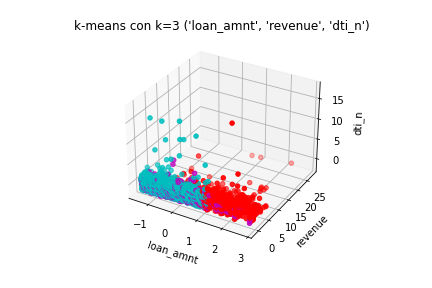

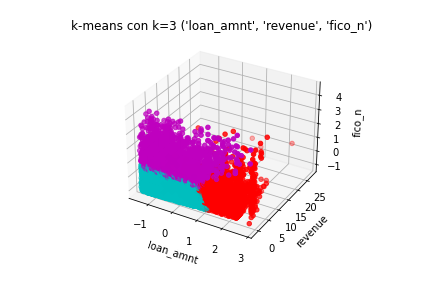

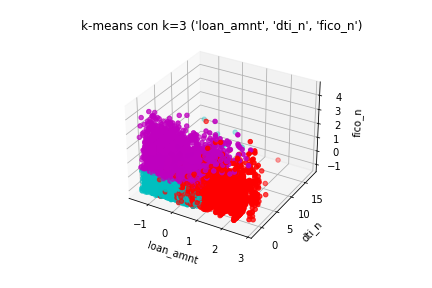

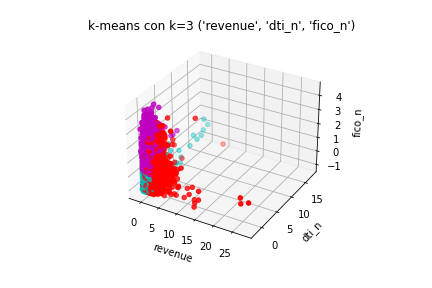

In [33]:
# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=3, random_state=333)

# Agrupar los puntos en clusters
km.fit(data_scaled)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

plot_clusters(data_scaled, labels, centers)

**Análisis:**

Las variables que menos conocimiento aportan son `revenue` y `dti_n` porque los resultados son muy similares entre sí. Esta similitud se puede apreciar muy bien en las gráficas 2 y 3. Sin embargo, es en estas 2 gráficas en las que mejor se diferencia la separación entre clusters, lo cual indica que las dos variables que mejor separan los clusters son `loan_amnt` y `fico`, ya que estando relacionadas entre sí la separación en clusters es la más clara de todas, da igual si la tercera variable es `revenue` o `dti_n`.

# FALTA POR HACER QUE LOS DATOS SEAN ESCALADOS PERO LAS ETIQUETAS SEAN LAS ORIGINALES (SIN ESCALAR). PONE EN EL ENUNCIADO QUE HAY QUE HACERLO ASÍ PERO NO SÉ CÓMO HACERLO.
# TAMBIÉN FALTA POR HACER EL PRIMER PÁRRAFO DEL ENUNCIADO (EL DE DESCRIPTORES ESTADÍSTICOS, PERO NO SÉ MUY BIEN A QUÉ SE REFIERE)